In [806]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

In [3]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

# Copied from last capstone project. 
def classifier_analysis(clf, X_test, y_test, plot=True, metric='evs'):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of 
              columns as X_test
        
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    if metric == 'evs':
        score = explained_variance_score(y_test, y_predict)
    elif metric == 'mae':
        score = mean_absolute_error(y_test, y_predict)
    else:
        score = mean_squared_error(y_test, y_predict)

#     print('Mean squared error {}'.format(mse_))
#     print('Explained variance score {}'.format(evs_))
    
    if plot:
        # Plot true vs. predicted as scatter plot. 
        ym = np.max(y_test)
        fig = plt.figure()
        plt.scatter(y_test, y_predict, s=1)
        plt.plot([0, ym],[0, ym],color='r')
        plt.ylabel('Predicted Value')
        plt.xlabel('True Value')
        plt.grid()
        plt.xlim([0, 1.1*ym])
        plt.ylim([0, 1.1*ym])
        _ = plt.show()
    
    return y_test, y_predict, score

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 0.5)
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    for i in range(1, X_train.shape[0]+1):
        # find the minima and maxima of all features for all countries, ranging up to current frame and 
        # each time step in the frame. 
        up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
        up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
        latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        if i == 1:
            frame_min_array = latest_min_array
            frame_max_array = latest_max_array
        else:
            frame_min_array = np.concatenate((frame_min_array, 
                                                   latest_min_array)
                                                  ,axis=0)
            frame_max_array = np.concatenate((frame_max_array, 
                                                   latest_max_array)
                                                  ,axis=0)

    # frame_min_array = np.tile(frame_min_array, (1, n_countries, 1, 1))
    # frame_max_array = np.tile(frame_max_array, (1, n_countries, 1, 1))

    minmax_denominator = (frame_max_array-frame_min_array)
    minmax_denominator[np.where(minmax_denominator==0)]=1
    X_train_scaled = (max_-min_)*(X_train - frame_min_array) / minmax_denominator
    # Use the latest min and max for test scaling.

    latest_minmax_denominator = latest_max_array - latest_min_array
    latest_minmax_denominator[np.where(latest_minmax_denominator==0)] = 1
    X_validate_scaled = (max_- min_)*((X_validate - np.tile(latest_min_array,(n_validation_frames,1,1,1)))
                                        / np.tile(latest_minmax_denominator,(n_validation_frames,1,1,1)))
    X_test_scaled = (max_- min_)*((X_test - np.tile(latest_min_array,(n_test_frames,1,1,1))) 
                                        / np.tile(latest_minmax_denominator,(n_test_frames,1,1,1)))
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 

    train_norm_arrays =  (frame_max_array, frame_min_array, minmax_denominator)
    validate_and_test_norm_arrays = (latest_max_array,latest_min_array,latest_minmax_denominator)

    return scaled_splits, train_norm_arrays, validate_and_test_norm_arrays

def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None

should have been average/taking min max over countries as well as time. 

be sure to check the definition of y when multiple countries. I think this is the definition from when using chronological data.

Things that have been discussed with mike that might need to be changed. predicting log(y) as opposed to y. 
using MAE instead of MSE. 
using pooling or not. 
filter numbers. 
Using one country, one feature. 

In [1012]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [1013]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# data = global_data
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data.loc[:, 'time_index'] += 1

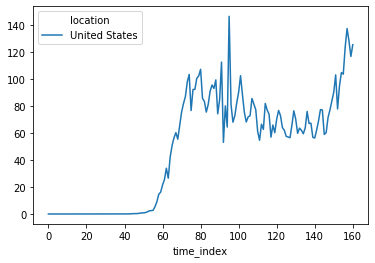

In [1014]:
per_country_plot(data[data.location.isin(data.groupby('location').max().new_cases_per_million.sort_values()[-10:].index)],'new_cases_per_million')

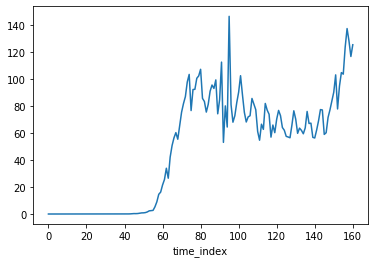

In [1015]:
per_country_plot(data, 'new_cases_per_million',legend=False)

# CNN model


Late to the party of why CNN model misbehaves sometimes; problem lies in the activation functions + dense layers; most common complication is that the output layer's weight is w<=0, meaning that upon multiplication with ReLU, it can only provide 0. 

In [1016]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 1:]
model_data =  model_data.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [1017]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
# if need to supply folds for sklearn CV regression functions.
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = scaled_splits

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()



X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
# y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
# y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
# y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()
y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


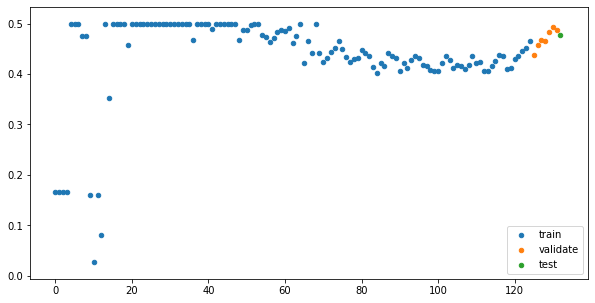

In [1018]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,0,-1,new_cases_index], s=20, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,0,-1,new_cases_index], s=20, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,0,-1,new_cases_index], s=20, label='test')
# ax.plot(np.log(data.new_cases_per_million.values[start_date-1:-1]+1), color='k', alpha=0.2)
# ax.plot(y, color='k')
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

In [1031]:
epochs = 100
learning_rate = 0.01
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
kernel_initializer0=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=0,
                                dtype=float)

cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
                kernel_constraint=non_neg(),
#                  activation='relu',
#                 kernel_initializer=kernel_initializer0
                )
         )

# cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling1D(pool_size=2))
kernel_initializer1=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=0,
                                dtype=float)

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,
                 kernel_constraint=non_neg(),

#                  activation='relu',
#                 kernel_initializer=kernel_initializer1
#                   use_bias=False
                )
         )


cnn_model.add(AveragePooling1D(pool_size=2))
# cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())

kernel_initializer2=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=2,
                                dtype=float)

cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu',
                use_bias=False,
                 kernel_constraint=non_neg(),
#                 kernel_initializer=kernel_initializer2
               )
         )

kernel_initializer3=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=0,
                                dtype=float)

cnn_model.add(Dense(1, 
                    activation='relu',
                    use_bias=False,
                     kernel_constraint=non_neg(),
#                     kernel_initializer=kernel_initializer3
                   ))
cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

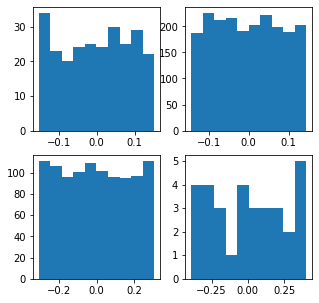

In [1032]:
fig, axes = plt.subplots(2,2, figsize=(5,5))
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [1033]:
history = cnn_model.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 125 samples, validate on 7 samples
Epoch 1/100
125/125 [==============================] - 3s 21ms/sample - loss: 13.9016 - val_loss: 0.0310
Epoch 2/100
125/125 [==============================] - 0s 72us/sample - loss: 1.5681 - val_loss: 1.1943
Epoch 3/100
125/125 [==============================] - 0s 64us/sample - loss: 1.5980 - val_loss: 1.1480
Epoch 4/100
125/125 [==============================] - 0s 72us/sample - loss: 1.5589 - val_loss: 0.0174
Epoch 5/100
125/125 [==============================] - 0s 72us/sample - loss: 1.3733 - val_loss: 0.0142
Epoch 6/100
125/125 [==============================] - 0s 72us/sample - loss: 1.4269 - val_loss: 0.3010
Epoch 7/100
125/125 [==============================] - 0s 80us/sample - loss: 1.2311 - val_loss: 0.6921
Epoch 8/100
125/125 [==============================] - 0s 72us/sample - loss: 1.3013 - val_loss: 0.5301
Epoch 9/100
125/125 [==============================] - 0s 80us/sample - loss: 1.2281 - val_loss: 0.1418
Epoch 10/100
125/12

Epoch 79/100
125/125 [==============================] - 0s 72us/sample - loss: 0.6666 - val_loss: 0.2554
Epoch 80/100
125/125 [==============================] - 0s 80us/sample - loss: 0.6662 - val_loss: 0.2565
Epoch 81/100
125/125 [==============================] - 0s 64us/sample - loss: 0.6657 - val_loss: 0.2645
Epoch 82/100
125/125 [==============================] - 0s 80us/sample - loss: 0.6652 - val_loss: 0.2659
Epoch 83/100
125/125 [==============================] - 0s 72us/sample - loss: 0.6648 - val_loss: 0.2589
Epoch 84/100
125/125 [==============================] - 0s 72us/sample - loss: 0.6643 - val_loss: 0.2548
Epoch 85/100
125/125 [==============================] - 0s 72us/sample - loss: 0.6639 - val_loss: 0.2592
Epoch 86/100
125/125 [==============================] - 0s 64us/sample - loss: 0.6635 - val_loss: 0.2637
Epoch 87/100
125/125 [==============================] - 0s 72us/sample - loss: 0.6630 - val_loss: 0.2609
Epoch 88/100
125/125 [==============================] -

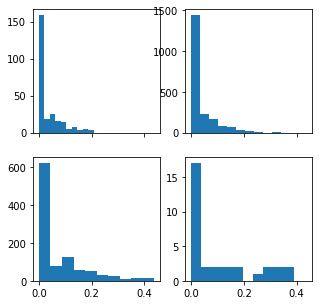

In [1034]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [1035]:
print(np.array(cnn_model.get_weights())[0].min(),
np.array(cnn_model.get_weights())[1].min(),
np.array(cnn_model.get_weights())[2].min(),
np.array(cnn_model.get_weights())[3].min())

-0.0 -0.0 -0.0 -0.0


In [1036]:
y_true.max(),y_train_naive.max(), y_predict.max()

(4.931180746755849, 146.61200000000002, 2908.8916)

In [1037]:
np.array(history.history['val_loss']).min()

0.014228121377527714

In [1038]:
np.array(history.history['val_loss']).argmin()

4

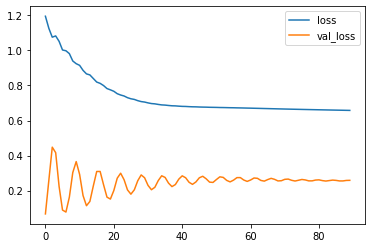

In [1039]:
_ = plt.plot(history.history['loss'][10:], label='loss')
_ = plt.plot(history.history['val_loss'][10:], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [3782.041027708779,0.6575105651308754]
1-step R^2 [Naive, CNN model] = [-409.6975334352284,0.7687336384978721]


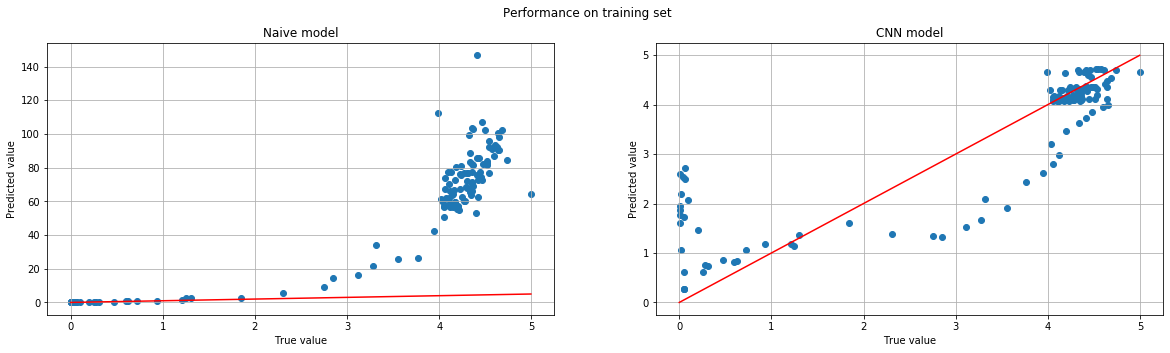

(125,) (125,) (125,)


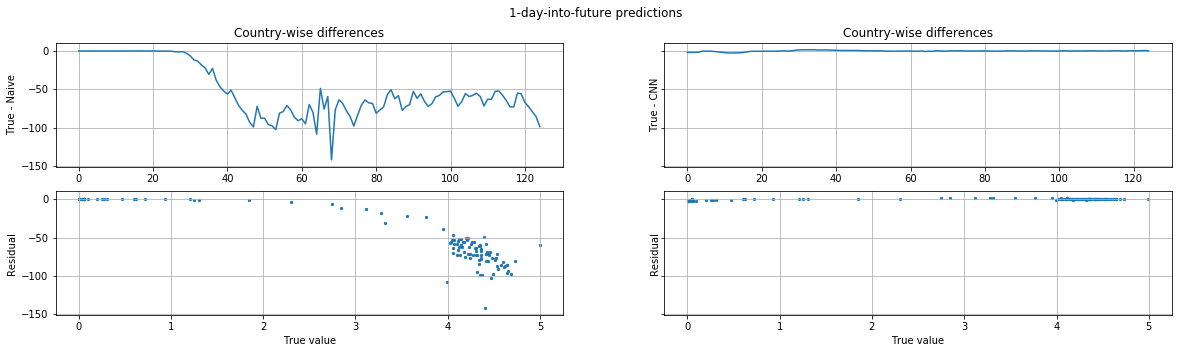

4.994587209674648 146.61200000000002 4.7203717


In [1040]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [11475.966651360663,0.2587286695850258]
1-step R^2 [Naive, CNN model] = [-24793.415984967512,0.5248704444075449]


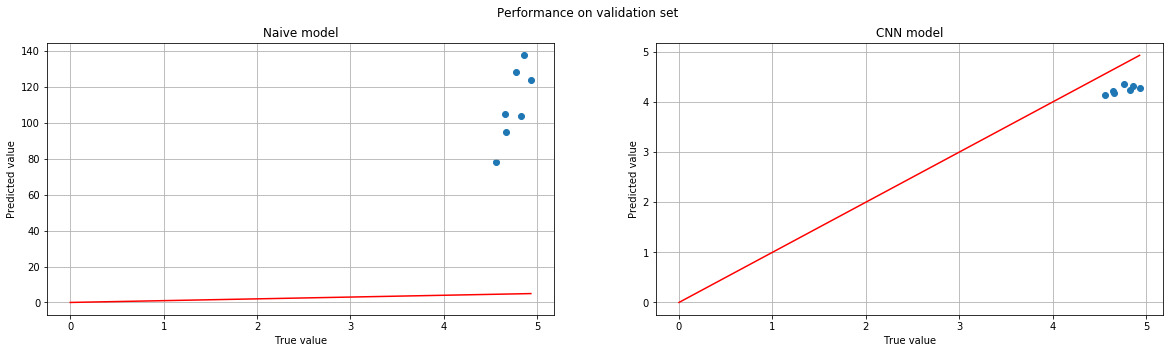

(7,) (7,) (7,)


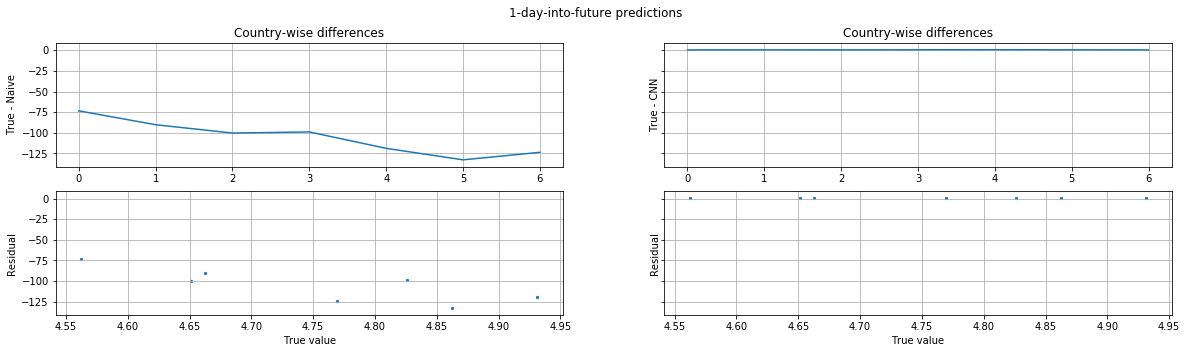

4.931180746755849 146.61200000000002 4.3498626


In [1042]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [1030]:
train_tile_shape = np.array(np.array(X_cnn_train.shape)/np.array(frame_denom.shape),int)
minmax_inverse_train = X_train - (((X_cnn_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))


validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
minmax_inverse_validate = X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))


test_tile_shape = np.array(np.array(X_cnn_test.shape)/np.array(latest_denom.shape),int)
minmax_inverse_test = X_test - (((X_cnn_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
print(np.linalg.norm(minmax_inverse_train),np.linalg.norm(minmax_inverse_validate),np.linalg.norm(minmax_inverse_test))

2.8084786336678716e-15 0.0 0.0


Time index to X relationship.

    Last frame, last day of X is time_index() - n_days_into_future
    last frame, first day is time_index() - n_days_into_future - frame_size
    first frame, first day is start_date-frame_size
    first frame, last day is start_date


Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

At first the following plot looks wrong because y looks like it is 1-day behind but this is only because I am
not providing the time values. I.e. the 5th value of y is actually the 6th value of X. 

In [ ]:
plt.plot(X[-30:,0,-1,:], label='x')
plt.plot(y[-30:], label='y')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

# Regression


In [915]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

I only use 1 feature in the CNN model, I understand that regression and CNN are fundamentally different but does
this mean I should only be using 1 feature for a fair baseline comparison?

In [916]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [917]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [918]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
(latest_max, latest_min, latest_denom) = latest_minmax

In [919]:
X_regression_train.max(), X_regression_train.min()

(146.612, 0.0)

In [920]:
X_regression_validate.max(), X_regression_validate.min()

(137.543, 56.389)

In [921]:
X_regression_test.max(), X_regression_test.min()

(137.543, 56.389)

In [922]:
print(X_regression_train.shape,X_regression_validate.shape,X_regression_test.shape)

(125, 28) (7, 28) (1, 28)


In [923]:
print(y_regression_train.shape,y_regression_validate.shape,y_regression_test.shape)

(125,) (7,) (1,)


Each row is a frame of frame_size days of new_cases_per_million data for a single country. So the number of rows equals
n_countries times frame_size

This transformation (slicing off last row) is because X_regression is both training and validation
data to be sliced by the train, validation indices passed to Ridge CV. i.e. the holdout set is being held out.

In [924]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [198.382250792,100.32805106976801]
1-step R^2 [Naive, Ridge regression model] = [0.8413462380389802,0.9196921269889909]


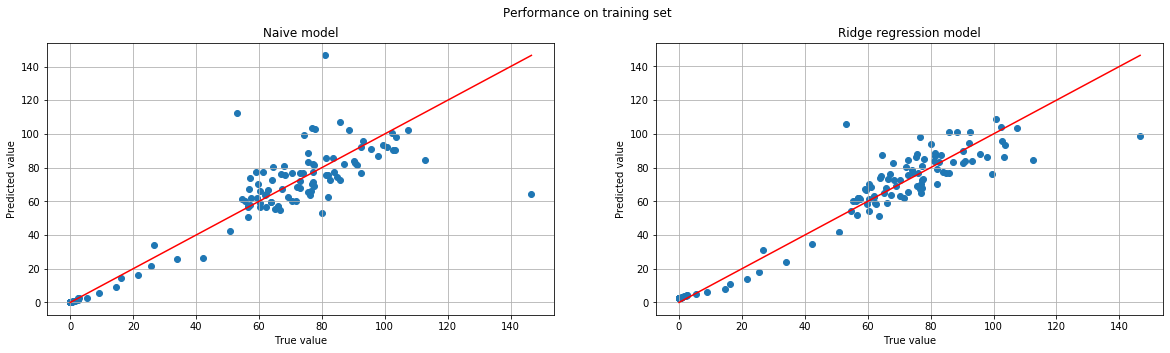

(125,) (125,) (125,)


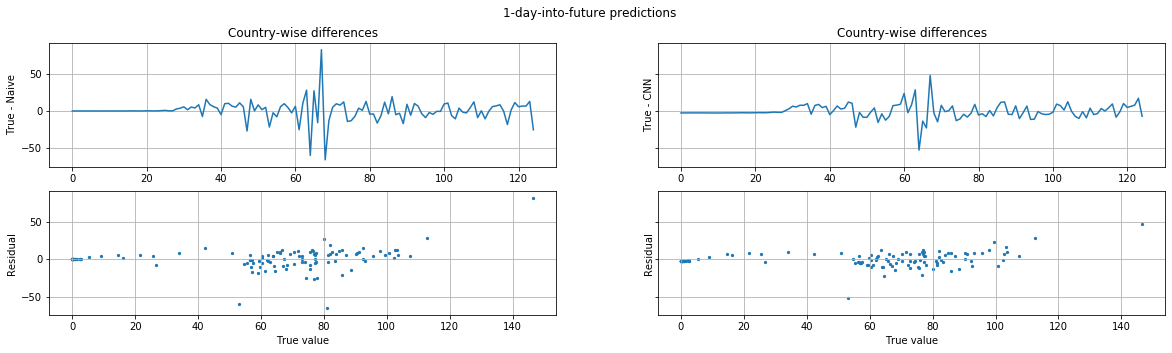

In [925]:
y_true = y_regression[train_indices]
y_naive =  y_train_naive
y_predict = regression_model.predict(X_regression_train).ravel()

model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge regression model', suptitle='Performance on training set')

There were 0 negative predictions
1-step MSE [Naive, Ridge regression model] = [170.80669257142873,111.08086446025358]
1-step R^2 [Naive, Ridge regression model] = [0.2994526992709322,0.6146030489864923]


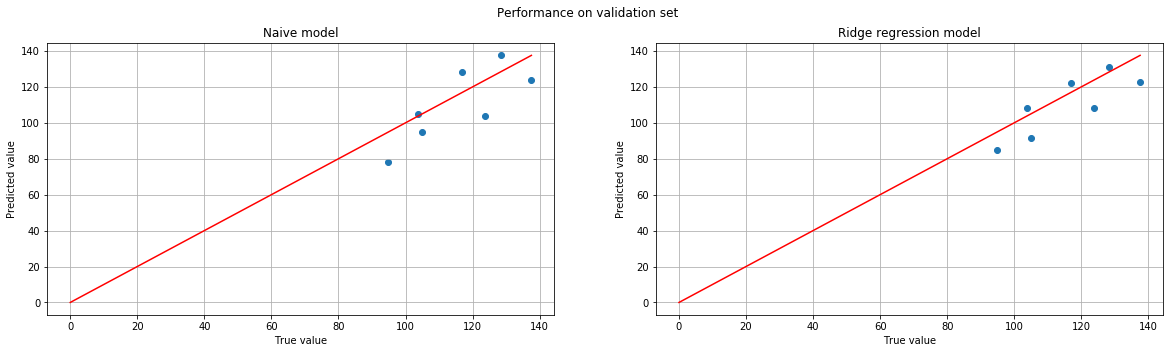

(7,) (7,) (7,)


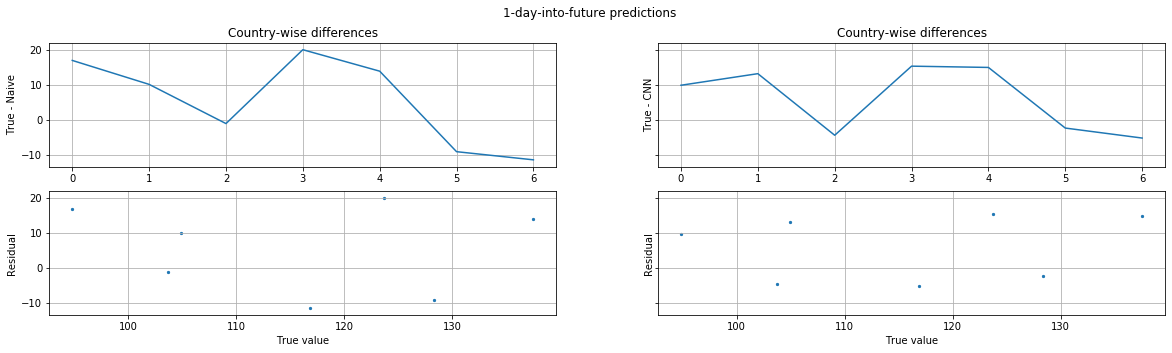

In [926]:
y_true = y_regression_validate.ravel()
y_naive =  y_validate_naive
y_predict = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_true, y_naive, y_predict, n_countries,title='Ridge regression model', suptitle='Performance on validation set')

# scaled single feature

In [928]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
r_model_data = r_data.new_cases_per_million.apply(lambda.to_frame().copy(); new_cases_index=0
#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [949]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = scaled_splits


Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [950]:
train_tile_shape = np.array(np.array(X_regression_train.shape) / np.array(frame_denom.shape),int)
minmax_inverse_train = X_train - (((X_regression_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))
np.linalg.norm(minmax_inverse_train)

0.0

In [953]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
minmax_inverse_validate = X_validate - (((X_regression_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
np.linalg.norm(minmax_inverse_validate)

7.78360568894479e-14

In [954]:
test_tile_shape = np.array(np.array(X_regression_test.shape)/np.array(latest_denom.shape),int)
minmax_inverse_test = X_test - (((X_regression_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
np.linalg.norm(minmax_inverse_test)

3.1776437161565096e-14

In [955]:
flat_splits = flatten_Xy_splits(scaled_splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [964]:
dir(regression_model)[-15:]

['alpha_',
 'alphas',
 'coef_',
 'cv',
 'fit',
 'fit_intercept',
 'gcv_mode',
 'get_params',
 'intercept_',
 'normalize',
 'predict',
 'score',
 'scoring',
 'set_params',
 'store_cv_values']

In [968]:
X_regression_validate.shape

(7, 28)

In [965]:
X_regression_validate.max()

0.4690714266226503

In [957]:
X_regression_test.max()

0.4690714266226503

In [960]:
y_predict_train

array([ -3.46271212,   0.99533499,  -0.62004212,  14.26264809,
       -13.3088589 ,  16.26289855,  15.67239718,  31.12038794,
        49.95543399,  39.91482394,  30.63685028,  39.09575606,
        26.54294996,  32.77655682,  29.59683127,  25.31323839,
        29.08572087,  14.01122663,  16.52822991,  23.27129851,
        24.3459409 ,  13.23443994,  12.89144048,  20.03051404,
        20.34327009,  16.33439591,  12.70208459,  25.11578399,
        31.274604  ,  10.08797267,   6.72858355,   2.66852376,
        12.58051746,  11.37251965,  20.41137428,  20.25663957,
        26.63957935,  27.67796459,  34.33762349,  36.52516198,
        41.69397012,  50.76639066,  57.45707294,  61.0763798 ,
        64.78764966,  66.83053886,  63.72227634,  67.68864405,
        65.03414138,  72.46689649,  84.53221362,  90.63390709,
        92.59494086,  90.37060574,  82.5916068 ,  84.33638173,
        87.8815098 ,  93.92919748, 101.74805404, 103.2418736 ,
        99.41671885,  99.46397974,  95.61656391, 102.47

There were 3 negative predictions
1-step MSE [Naive, Ridge] = [198.382250792,356.78679259656167]
1-step R^2 [Naive, Ridge] = [0.8413462380389802,0.7165900210578352]


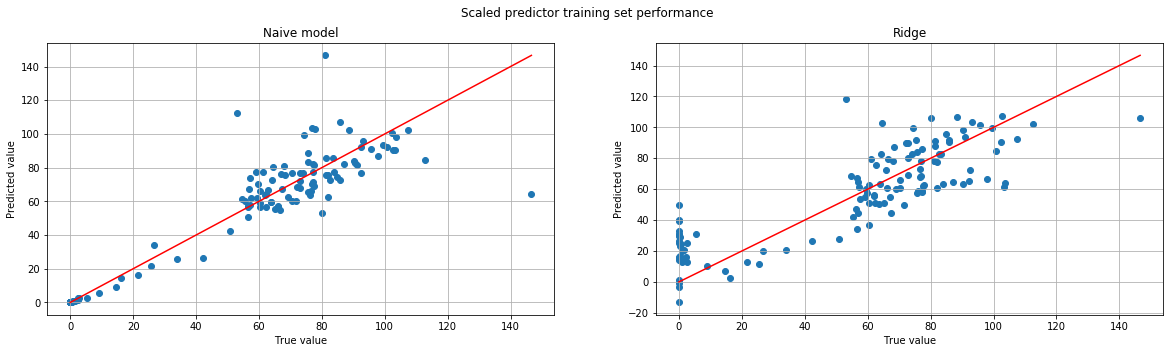

(125,) (125,) (125,)


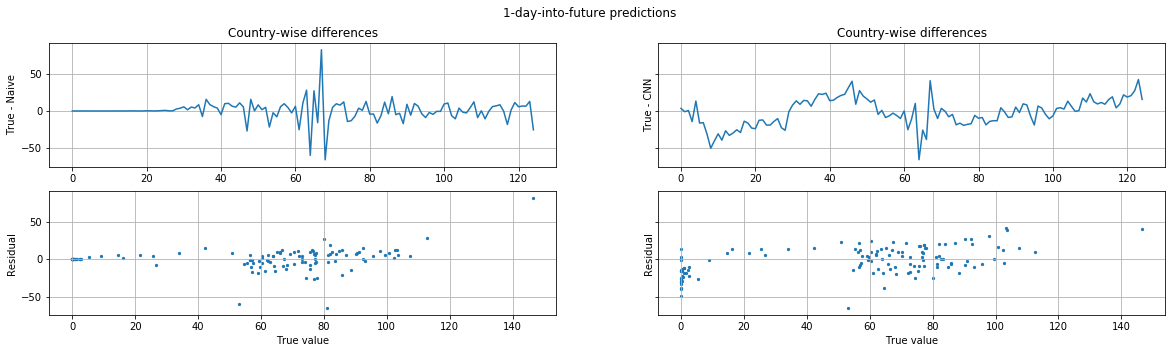

In [958]:
y_predict_train = regression_model.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, 
               title='Ridge', suptitle='Scaled predictor training set performance')

There were 0 negative predictions
1-step MSE [Naive, Ridge] = [170.80669257142873,1052.0112992530428]
1-step R^2 [Naive, Ridge] = [0.2994526992709322,0.6857095601437939]


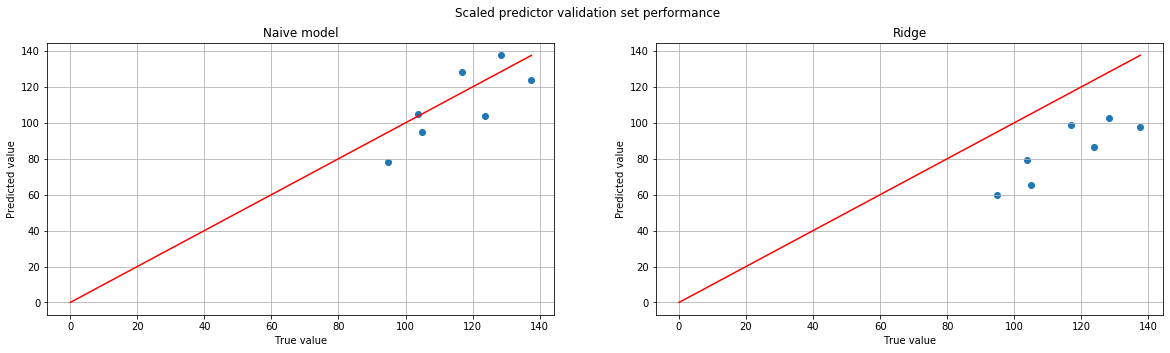

(7,) (7,) (7,)


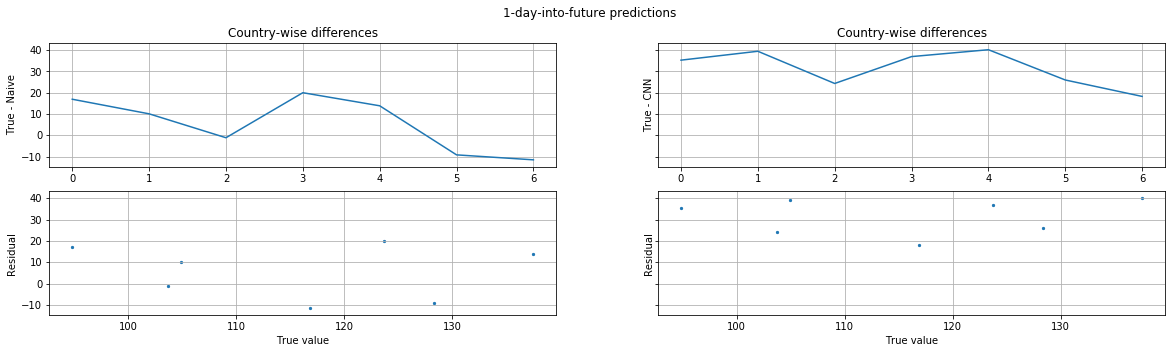

In [959]:
y_true = y_regression_validate.ravel()
y_naive =  y_validate_naive
y_predict = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# "All" feature prediction

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
r_model_data = r_data.iloc[:,2:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index
frame_size = 28
start_date = 2*frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

# Final predictions for comparison

In [26]:
y

array([[  5.335],
       [  9.027],
       [ 14.607],
       [ 16.236],
       [ 21.519],
       [ 25.556],
       [ 33.945],
       [ 26.553],
       [ 42.184],
       [ 50.746],
       [ 56.48 ],
       [ 60.359],
       [ 55.468],
       [ 65.241],
       [ 75.522],
       [ 81.882],
       [ 87.066],
       [ 97.96 ],
       [103.54 ],
       [ 76.731],
       [ 92.329],
       [ 92.486],
       [100.673],
       [102.419],
       [107.331],
       [ 85.773],
       [ 83.443],
       [ 75.598],
       [ 81.335],
       [ 91.081],
       [ 95.67 ],
       [ 93.15 ],
       [ 99.461],
       [ 74.323],
       [ 84.788],
       [112.655],
       [ 53.136],
       [ 80.19 ],
       [ 64.507],
       [146.612],
       [ 81.138],
       [ 68.099],
       [ 72.906],
       [ 82.555],
       [ 90.383],
       [102.582],
       [ 88.483],
       [ 75.444],
       [ 68.256],
       [ 72.027],
       [ 72.894],
       [ 85.706],
       [ 81.44 ],
       [ 77.377],
       [ 61.202],
       [ 5

In [ ]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)


# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits = normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None)

flat_splits = flatten_Xy_splits(scaled_splits)

(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

In [ ]:
y_naive = X_test
y_true = y_test
y_predict_r = regression_model.predict(X_test)
y_predict_c = cnn_model.predict(X_test)

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index <= max_date_in_window) & 
#                             (time_index > max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
#     if max_date_in_window == start_date:
#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)

        
# y = target_data.values[-X.shape[0]:].reshape(-1,1)
# y_time_index = time_index.values[-X.shape[0]:].reshape(-1,1)
# # y = target_data.values.transpose()[-X.shape[0]:,:]
# # y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:]

# y_train =  y[:-(n_validation_frames+n_test_frames),:]
# y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
# y_train =  y[:-(n_validation_frames+n_test_frames),:]
# X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
# y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# X_test = X[-n_test_frames:, :, :, :] 
# y_test = y[-n_test_frames:, :]
# splits =  (X_train, y_train, X_validate, y_validate,
#            X_test, y_test)

# y_train_time = y_time_index[:-(n_validation_frames+n_test_frames),:]
# y_validate_time = y_time_index[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# y_test_time = y_time_index[-n_test_frames:, :]

# Before normalization, plot the splits 

#     # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
#     # of steps to predict in the future, this is only slicing the frames. 
#     if train_test_only:
#         (X_train, y_train, X_test, y_test) = splits
#     else:
#         (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits

# #     if normalization_method=='minmax':
#         # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
#         # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
#         # There is only a single value per feature in this case, meaning that to rescale, the values need to
#         # be repeated for each validation, test frame for each country for each timestep.
#     X_min = X_train.min(axis=(2))
#     X_max = X_train.max(axis=(2))


#     X_train_scaled = minmax(X_train, X_min[:, :, np.newaxis, :],
#                     X_max[:, :, np.newaxis, :])
#     X_test_scaled = minmax(X_test, X_min[-1][np.newaxis, :, np.newaxis, :], 
#                            X_max[-1][np.newaxis, :, np.newaxis, :])
#     if train_test_only:
#     # Normalize the training data by each frame's specific mean and std deviation. 
#         splits = (X_train_scaled, y_train, X_test_scaled, y_test)
#     else:
#         X_validate_scaled = minmax(X_validate, X_min[-1,:][np.newaxis, :, np.newaxis, :], 
#                                    X_max[-1,:][np.newaxis, :, np.newaxis, :])
#         splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)


In [242]:
y_train_naive

array([  2.68 ,   5.335,   9.027,  14.607,  16.236,  21.519,  25.556,
        33.945,  26.553,  42.184,  50.746,  56.48 ,  60.359,  55.468,
        65.241,  75.522,  81.882,  87.066,  97.96 , 103.54 ,  76.731,
        92.329,  92.486, 100.673, 102.419, 107.331,  85.773,  83.443,
        75.598,  81.335,  91.081,  95.67 ,  93.15 ,  99.461,  74.323,
        84.788, 112.655,  53.136,  80.19 ,  64.507, 146.612,  81.138,
        68.099,  72.906,  82.555,  90.383, 102.582,  88.483,  75.444,
        68.256,  72.027,  72.894,  85.706,  81.44 ,  77.377,  61.202,
        54.734,  66.61 ,  62.785,  82.002,  77.063,  73.978,  57.018,
        65.984,  60.332,  70.347,  76.839,  72.951,  64.157,  62.138,
        57.595,  57.129,  56.558,  65.912,  76.546,  70.383,  59.839,
        63.703,  62.066,  59.513,  63.867,  76.066,  67.138,  67.377,
        56.864,  56.389,  62.277,  69.132,  77.459,  77.16 ,  59.042,
        60.293,  71.616,  77.217,  83.872,  90.359, 103.196])

In [ ]:
# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index <= max_date_in_window - 1) & 
#                             (time_index >= max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
# #     break
#     if max_date_in_window == start_date:
#         print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)

#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)
# print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
# y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
